In [110]:
import json
import numpy as np
import tensorflow as tf
import statistics
from tensorflow.keras import layers
from tensorflow.keras import losses
import random

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [111]:
with open("train.json") as f:
    train_set = json.load(f)
random.shuffle (train_set)

cnt = 0
ingredient_to_id = {}
ingredient_to_cnt = {}
ingredients = []

cuisine_cnt = 0
cuisine_to_id = {}
cuisine_to_cnt = {}
cuisines = []

valuecount_cnt = 0
valuecount_to_id = {}
valuecount_to_cnt = {}
valuecounts = []

for item in train_set:
    cuisine = item['cuisine']
    if cuisine not in cuisine_to_id:
        cuisine_to_id[cuisine] = cuisine_cnt
        cuisine_cnt += 1
        cuisine_to_cnt[cuisine] = 1
        cuisines.append(cuisine)
    else:
        cuisine_to_cnt[cuisine] += 1

    valuecount = len(item['ingredients'])
    valuecounts.append(valuecount)
    if valuecount not in valuecount_to_id:
        valuecount_to_id[valuecount] = valuecount_cnt
        valuecount_cnt += 1
        valuecount_to_cnt[valuecount] = 1
    else:
        valuecount_to_cnt[valuecount] += 1

    for ingredient in item['ingredients']:
        if ingredient not in ingredient_to_id:
            ingredient_to_id[ingredient] = cnt
            cnt += 1
            ingredient_to_cnt[ingredient] = 1
            ingredients.append(ingredient)
        else:
            ingredient_to_cnt[ingredient] += 1

[('italian', 5910), ('mexican', 4784), ('southern_us', 3279), ('indian', 2249), ('french', 2009), ('chinese', 1980), ('cajun_creole', 1159), ('thai', 1146), ('japanese', 1055), ('greek', 875), ('spanish', 748), ('moroccan', 630), ('vietnamese', 618), ('korean', 609), ('british', 586), ('filipino', 553), ('irish', 485), ('jamaican', 408), ('russian', 348), ('brazilian', 343)]


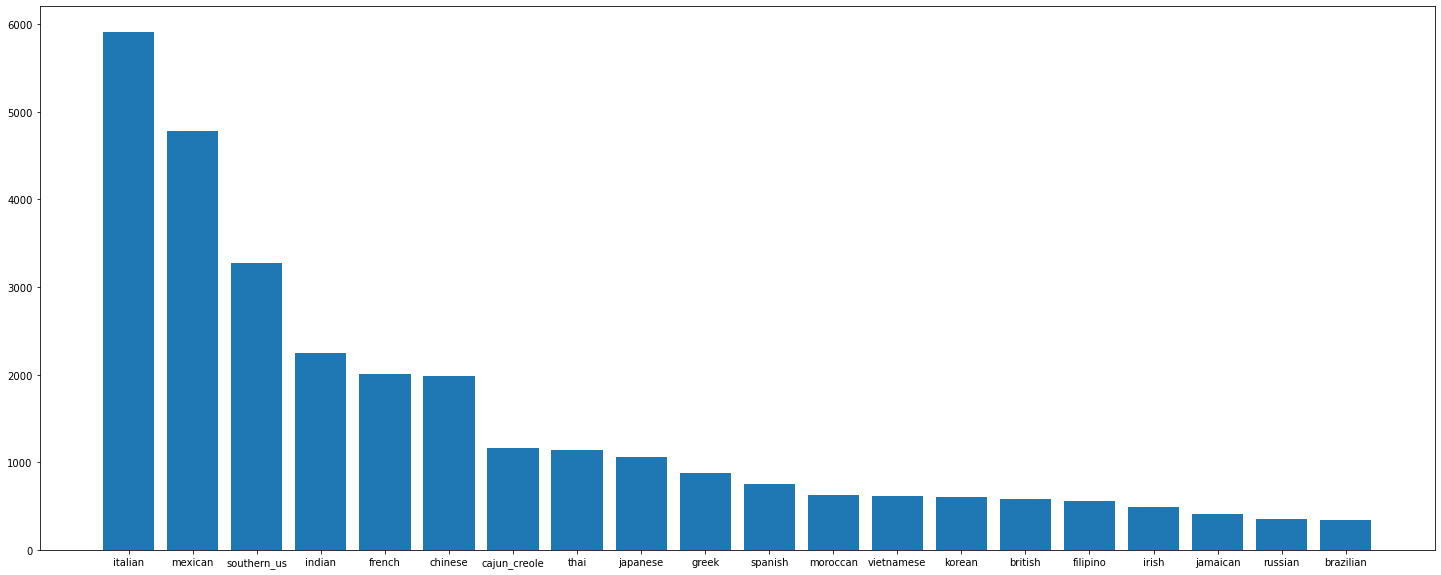

In [112]:
temp = sorted(cuisine_to_cnt.items(), key=lambda item: item[1])
temp.reverse()
print(temp)

x_list = []
y_list = []
for i in temp:
    x_list.append(i[0])
    y_list.append(i[1])
plt.figure(figsize=(25,10))
plt.bar(x_list, y_list)
plt.show()

[('pepper', 19165), ('salt', 18324), ('oil', 17424), ('garlic', 14152), ('ground', 13638), ('fresh', 13468), ('sauce', 9558), ('sugar', 9324), ('onions', 9266), ('cheese', 8695), ('chicken', 8519), ('olive', 8239), ('black', 7928), ('water', 7329), ('red', 6837), ('flour', 6592), ('butter', 6472), ('green', 6444), ('tomatoes', 6441), ('powder', 6141), ('chopped', 5945), ('cloves', 5625), ('juice', 5397), ('onion', 5192), ('white', 5180), ('eggs', 4870), ('rice', 4525), ('cream', 4488), ('cilantro', 4458), ('milk', 4384)]


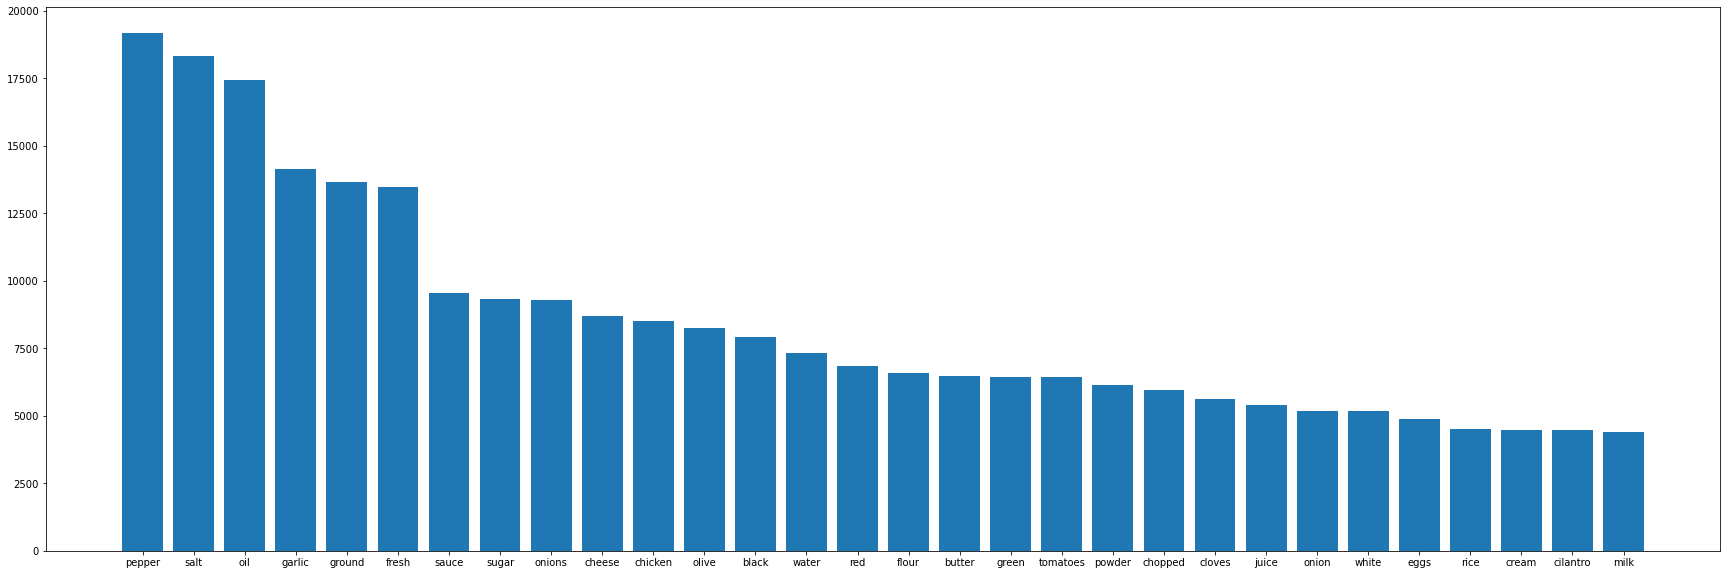

In [113]:
temp = sorted(ingredient_to_cnt.items(), key=lambda item: item[1])
temp.reverse()
temp = temp[:30]
print(temp)

x_list = []
y_list = []
for i in temp:
    x_list.append(i[0])
    y_list.append(i[1])
plt.figure(figsize=(30,10))
plt.bar(x_list, y_list)
plt.show()

[(9, 2796), (10, 2763), (8, 2673), (11, 2606), (7, 2533), (12, 2352), (13, 2045), (6, 1971), (14, 1704), (5, 1424), (15, 1316), (16, 1093), (17, 891), (4, 826), (18, 639), (19, 465), (3, 406), (20, 363), (21, 244), (22, 169), (2, 137), (23, 98), (24, 67), (25, 56), (26, 33), (28, 22), (1, 17), (29, 13), (30, 11), (31, 10), (27, 10), (33, 4), (35, 3), (40, 2), (49, 2), (34, 2), (32, 2), (36, 2), (65, 1), (52, 1), (59, 1), (43, 1)]


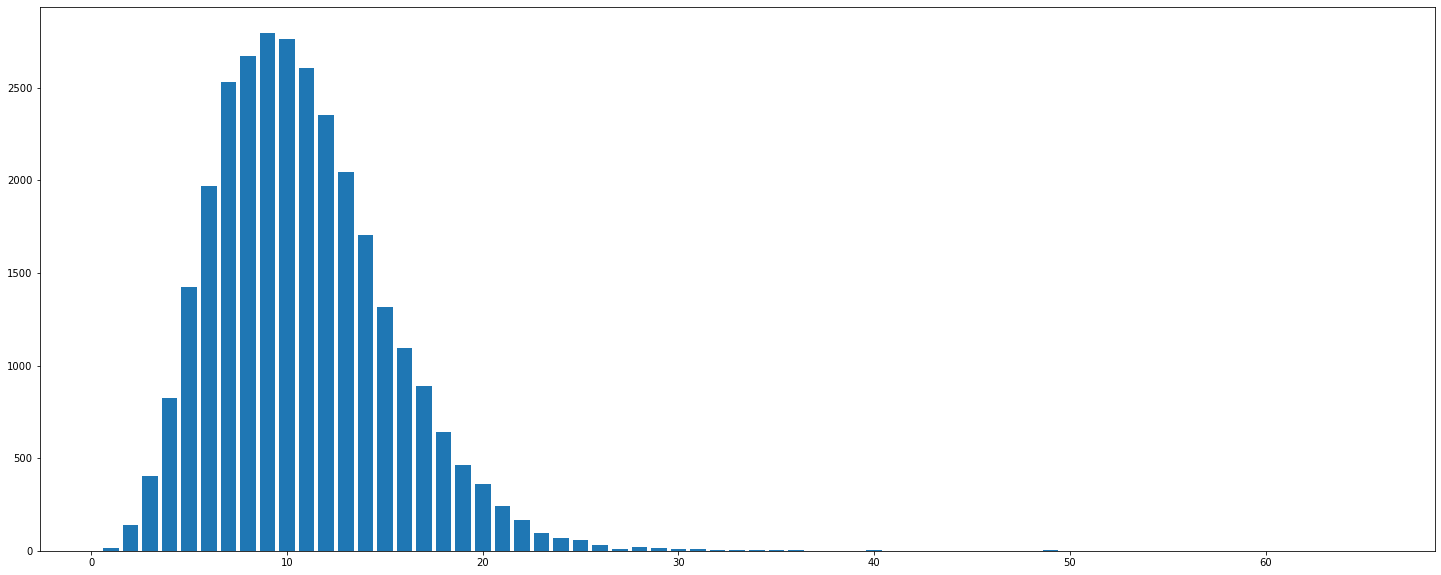

In [114]:
temp = sorted(valuecount_to_cnt.items(), key=lambda item: item[1])
temp.reverse()
print(temp)

x_list = []
y_list = []
for i in temp:
    x_list.append(i[0])
    y_list.append(i[1])
plt.figure(figsize=(25,10))
plt.bar(x_list, y_list)
plt.show()

In [116]:
mean = statistics.mean(valuecounts)
stdev = statistics.stdev(valuecounts)
print(mean)
print(stdev)
x = np.zeros((len(train_set), cnt+1), np.float)
y = np.zeros((len(train_set), cuisine_cnt), np.float)
for id, item in enumerate(train_set):
    for ingredient in item['ingredients']:
        x[id][ ingredient_to_id[ingredient] + 1 ] = 1.0
    x[id][0] = (valuecounts[id] - mean) / stdev
    y[id][ cuisine_to_id[item['cuisine']] ] = 1.0


10.770269362531067
4.4239170766871725


In [117]:
size_list = [6400, 1600, 400, 100]
model = tf.keras.Sequential()
for i in size_list:
    model.add(layers.Dense(i))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.2))
model.add(layers.Dense(20, activation='softmax'))

train_size = int(len(train_set) * 0.8)
x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[train_size:]
y_test = y[train_size:]

print(x.shape)
print(y.shape)

print(x_train.shape)
print(y_train.shape)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history =  model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.3)
model.summary()


(29774, 3351)
(29774, 20)
(23819, 3351)
(23819, 20)
Epoch 1/5
522/522 [==============================] - 12s 21ms/step - loss: 1.4718 - accuracy: 0.5850 - val_loss: 0.8436 - val_accuracy: 0.7517
Epoch 2/5
522/522 [==============================] - 11s 21ms/step - loss: 0.7229 - accuracy: 0.7919 - val_loss: 0.8442 - val_accuracy: 0.7517
Epoch 3/5
522/522 [==============================] - 11s 21ms/step - loss: 0.5323 - accuracy: 0.8433 - val_loss: 0.8845 - val_accuracy: 0.7478
Epoch 4/5
522/522 [==============================] - 11s 21ms/step - loss: 0.4295 - accuracy: 0.8742 - val_loss: 0.9362 - val_accuracy: 0.7410
Epoch 5/5
522/522 [==============================] - 11s 20ms/step - loss: 0.3525 - accuracy: 0.8932 - val_loss: 0.9620 - val_accuracy: 0.7478
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 6400)              21452800  
____________

<Figure size 1080x1080 with 0 Axes>

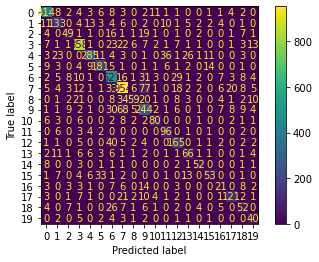

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       471
           1       0.64      0.66      0.65       201
           2       0.57      0.47      0.51       105
           3       0.89      0.90      0.90       955
           4       0.86      0.70      0.77       408
           5       0.74      0.76      0.75       238
           6       0.71      0.80      0.75       652
           7       0.82      0.82      0.82      1158
           8       0.68      0.34      0.45       174
           9       0.55      0.61      0.58       399
          10       0.75      0.70      0.72       114
          11       0.62      0.83      0.71       115
          12       0.66      0.71      0.69       231
          13       0.54      0.58      0.56       114
          14       0.74      0.73      0.74        71
          15       0.62      0.43      0.51       122
          16       0.36      0.30      0.33        71
          17       0.75    

In [118]:
y_pred = model(x_test)
y_pred = tf.argmax(y_pred, axis=1)
y_test = tf.argmax(y_test, axis=1)
plt.figure(figsize=(15,15))
CM = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=CM).plot()
plt.show()
print(report)

In [119]:
with open("test.json") as f:
    test_set = json.load(f)

id_list = []
x_data = np.zeros((len(test_set), cnt+1), np.float)
for id, item in enumerate(test_set):
    id_list.append(item['id'])
    for ingredient in item['ingredients']:
        if ingredient in ingredient_to_id:
            x_data[id][ ingredient_to_id[ingredient] + 1 ] = 1.0
        else:
            #print(ingredient)
            pass
        x_data[id][0] = (len(item['ingredients']) - mean) / stdev
        
            
y_data = model(x_data)
index = tf.argmax(y_data, axis=1)
with open("submission.csv", "w") as submission:
    submission.write("id,Category\n")
    for i in range(len(id_list)):
        submission.write(str(id_list[i])+","+cuisines[index[i]]+"\n")